/home/matwayi/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.0, 1.0, 'MSLP (hPa) with Highs and Lows, 1000-500 hPa Thickness (m)')

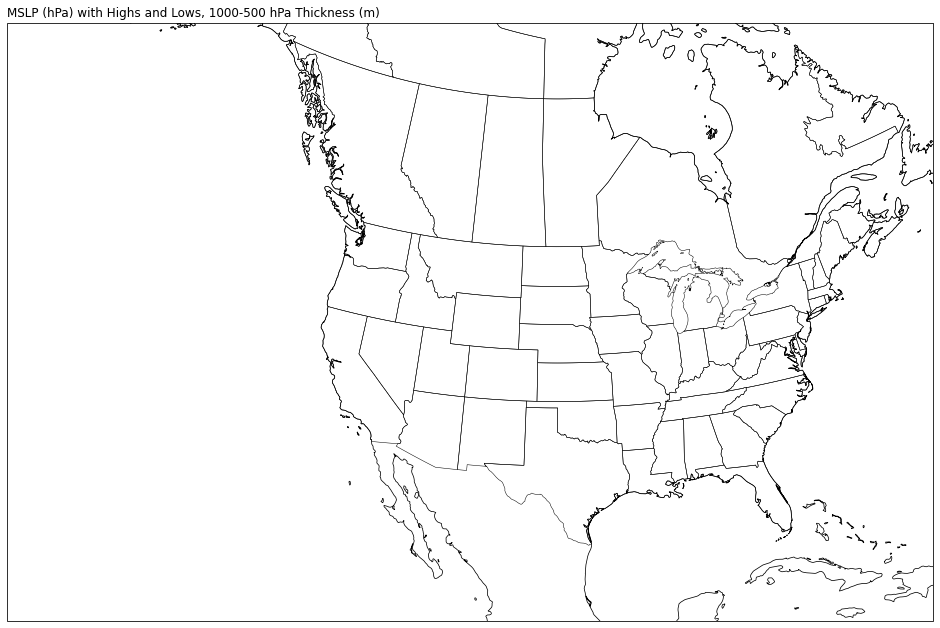

In [18]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from metpy.units import units
from netCDF4 import num2date
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog

#Function for finding and plotting max/min points

def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None, ax=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    ax = axes object to plot onto, defaults to current axes
    The max/min symbol will be plotted only within the bounding frame
    (i.e., clip_on=True, clip_box=ax.bbox)
    """
    import matplotlib.pyplot as plt
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if ax is None:
        ax = plt.gca()
    
    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                     clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                     transform=transform)
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                     '\n' + str(np.int(data[mxy[i], mxx[i]])),
                     color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                     horizontalalignment='center', verticalalignment='top', transform=transform)
#Get NARR data
# Specify our date/time of product desired
#dt = datetime(1999, 1, 3, 0)

# Assemble our URL to the NCEI THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
#base_url = 'https://www.ncei.noaa.gov/thredds/model-narr-a-files/'
#cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
#ncss = cat.datasets[f'narr-a_221_{dt:%Y%m%d}_{dt:%H}00_000.grb'].subset()

# Create a NCSS query to add specifications to
#query = ncss.query()

#query.all_times()
#query.add_lonlat()
#query.accept('netcdf')
#query.variables('Pressure_reduced_to_MSL_msl',
#                'Geopotential_height_isobaric')

# Obtain the data we want to query for
#data = ncss.get_data(query)
#Extract data into variables
rep_data1='/mnt/g/ERA_5_wspd_slp/wrf_schemes_d01/Era_wrf_data/Era/' #Home
#"G:\ERA_5_wspd_slp\wrf_schemes_d01\Era_wrf_data\Kenneth" Home
#
data=rep_data1+'eUV10_mslp_01.nc' #u10,v10, mslp
data=xr.open_dataset(data)
data = data.sel(time=slice('2019-04-25T15:00:00')).load() #,'2019-4-25'))
#many_times=np.array(['2019-03-15T00:00:00','2019-04-25T15:00:00'],dtype=np.datetime64)
#ds =ds.sel(time=many_times, method='nearest').mean('time') #2019-04-25T15:00:00
#ds =ds.sel(time='2019-04-25T15:00:00', method='nearest').mean('time') #2019-04-25T15:00:00


#Read variables
#t2m=ds.variables['t2m'][:].squeeze()
#sp=ds.variables['sp'][:].squeeze()
#u10=ds.variables['u10'][:].squeeze()
#v10=ds.variables['v10'][:].squeeze()
lons=data.variables['longitude'][:]#.squeeze()
lats=data.variables['latitude'][:]#.squeeze()

# Grab pressure levels
#plev = list(data.variables['isobaric1'][:])

# Grab lat/lons and make all lons 0-360
#lats = data.variables['lat'][:]
#lons = data.variables['lon'][:]
#lons[lons < 0] = 360 + lons[lons < 0]

# Grab valid time and get into datetime format
#time = data['time2']
#vtime = num2date(time[:].squeeze(), units=time.units)

# Grab MSLP and smooth, use MetPy Units module for conversion
slp = data.variables['sp']
#EMSL = units.Quantity(emsl_var[:], emsl_var.units).to('hPa')
mslp = gaussian_filter(slp[0], sigma=3.0)

# Grab pressure level data
#hght_1000 = data.variables['Geopotential_height_isobaric'][0, plev.index(1000)]
#hght_500 = data.variables['Geopotential_height_isobaric'][0, plev.index(500)]

# Calculate and smooth 1000-500 hPa thickness
#thickness_1000_500 = gaussian_filter(hght_500 - hght_1000, sigma=3.0)
#Set map and data projections for use in mapping

# Set projection of map display
mapproj = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.)

# Set projection of data
dataproj = ccrs.PlateCarree()

# Grab data for plotting state boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')
#Create figure and plot data

fig = plt.figure(1, figsize=(17., 11.))
ax = plt.subplot(111, projection=mapproj)

# Set extent and plot map lines
ax.set_extent([-145., -70, 20., 60.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot thickness with multiple colors
clevs = (np.arange(0, 5400, 60),
         np.array([5400]),
         np.arange(5460, 7000, 60))
colors = ('tab:blue', 'b', 'tab:red')
kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
for clevthick, color in zip(clevs, colors):
    cs = ax.contour(lons, lats, mslp, levels=clevthick, colors=color,
                    linewidths=1.0, linestyles='dashed', transform=dataproj)
    plt.clabel(cs, **kw_clabels)

# Plot MSLP
clevmslp = np.arange(800., 1120., 4)
cs2 = ax.contour(lons, lats, mslp, clevmslp, colors='k', linewidths=1.25,
                 linestyles='solid', transform=dataproj)
plt.clabel(cs2, **kw_clabels)

# Use definition to plot H/L symbols
#plot_maxmin_points(lons, lats, mslp, 'max', 50, symbol='H', color='b', transform=dataproj)
#plot_maxmin_points(lons, lats, mslp, 'min', 25, symbol='L', color='r', transform=dataproj)

# Put on some titles
plt.title('MSLP (hPa) with Highs and Lows, 1000-500 hPa Thickness (m)', loc='left')
#plt.title(f'VALID: {vtime}', loc='right')

In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from netCDF4 import Dataset
from wrf import to_np, getvar, smooth2d, get_basemap, ll_to_xy, latlon_coords, interplevel, get_cartopy, cartopy_xlim, cartopy_ylim
import numpy as np
import netCDF4
import datetime
import matplotlib
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import sys
rep_data='/mnt/g/ERA_5_wspd_slp/wrf_schemes_d01/Era_wrf_data/Kenneth/' #Home
nc =Dataset(rep_data+'wrfout_d01_08.nc')
t2datetime = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S')

def wrf_time(nc):
    first = ''.join([x.decode('utf-8') for x in nc['Times'][0]])
    return t2datetime(first)

def total_prec(nc, nc_prev):
    prec_vars = ['RAINC', 'RAINSH', 'RAINNC', 'SNOWNC', 'GRAUPELNC', 'HAILNC']
    start = t2datetime(nc.START_DATE)
    prec = np.sum([nc[var][0, :, :] for var in prec_vars], axis=0)

    if start == wrf_time(nc):
        return prec
    else:
        prec_p = np.sum([nc_prev[var][0, :, :] for var in prec_vars], axis=0)
        return prec-prec_p

def add_title_and_description(nc, title, ax):
    '''
    title: including {init:s} for timestamp of run initialization, and {fcsthour:d} for forecast hour
    '''
    fcstHour = int((wrf_time(nc) - t2datetime(nc.START_DATE)).total_seconds()/3600.)
    
    ax.set_title(title.format(init=t2datetime(nc.START_DATE).strftime("%d.%m.%Y %H:%M UTC"), 
                              fcsthour=fcstHour), fontdict={ 'fontsize':8, 'horizontalalignment': 'left'}, loc='left')

    texttime = AnchoredText(wrf_time(nc).strftime("%H UTC %a"), 
                            loc=2, pad=0.2, prop={'size': 10}, frameon=True)
    ax.add_artist(texttime)

    textcopyright = AnchoredText("$\copyright$ Meteorological Institute Munich, LMU",
                        loc=4, pad=0.1, prop={'size': 6, 'color':'white'}, frameon=False)
    ax.add_artist(textcopyright)

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from wrf import to_np, getvar, smooth2d, get_basemap, ll_to_xy, latlon_coords, interplevel, get_cartopy, cartopy_xlim, cartopy_ylim
import numpy as np
import netCDF4
import datetime
import matplotlib
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import sys


t2datetime = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d_%H:%M:%S')

def wrf_time(nc):
    first = ''.join([x.decode('utf-8') for x in nc['Times'][0]])
    return t2datetime(first)

def total_prec(nc, nc_prev):
    prec_vars = ['RAINC', 'RAINSH', 'RAINNC', 'SNOWNC', 'GRAUPELNC', 'HAILNC']
    start = t2datetime(nc.START_DATE)
    prec = np.sum([nc[var][0, :, :] for var in prec_vars], axis=0)

    if start == wrf_time(nc):
        return prec
    else:
        prec_p = np.sum([nc_prev[var][0, :, :] for var in prec_vars], axis=0)
        return prec-prec_p

def add_title_and_description(nc, title, ax):
    '''
    title: including {init:s} for timestamp of run initialization, and {fcsthour:d} for forecast hour
    '''
    fcstHour = int((wrf_time(nc) - t2datetime(nc.START_DATE)).total_seconds()/3600.)
    
    ax.set_title(title.format(init=t2datetime(nc.START_DATE).strftime("%d.%m.%Y %H:%M UTC"), 
                              fcsthour=fcstHour), fontdict={ 'fontsize':8, 'horizontalalignment': 'left'}, loc='left')

    texttime = AnchoredText(wrf_time(nc).strftime("%H UTC %a"), 
                            loc=2, pad=0.2, prop={'size': 10}, frameon=True)
    ax.add_artist(texttime)

    textcopyright = AnchoredText("$\copyright$ Meteorological Institute Munich, LMU",
                        loc=4, pad=0.1, prop={'size': 6, 'color':'white'}, frameon=False)
    ax.add_artist(textcopyright)
